In [105]:
import os
import pandas as pd
import numpy as np
import itertools
import joblib
# Matplot libraries
from matplotlib import pyplot as plt
# SkLearn libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif, f_classif, chi2
from sklearn.model_selection import GridSearchCV,LeavePGroupsOut, StratifiedGroupKFold, GroupKFold, GroupShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
# Tensorflow libraries
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

In [106]:
# Change root directory
dirPath = r'C:\Users\Andreas\Desktop\Thesis\Data'
os.chdir(dirPath)
print('Current working directory: {0}'.format(os.getcwd()))

Current working directory: C:\Users\Andreas\Desktop\Thesis\Data


In [107]:
def read_csv(features, dirPath = dirPath):
        
    for file in os.listdir(dirPath):
        if features in file:
            df = pd.read_csv(file, delimiter=',', encoding = 'utf-8')
    return df

In [108]:
def prepare_df(df, secluded_sensors):

    # Drop sensor data
    for sensor in secluded_sensors:
        df = df.drop(df.columns[df.columns.str.contains(sensor)], axis=1)

    # Labelled samples
    training_df = df.drop(df[df.label == 'TBD'].index)

    return training_df

In [109]:
def plot_confusion_matrix(cm, classes):
    
    plt.figure(figsize = (8,7))
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
    cbar = plt.colorbar(im)
    cbar.set_label('Fraction', rotation=90)
    
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
              horizontalalignment="center",
              color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [110]:
def plot_importances(importances, features):

    plt.figure(figsize = (10,10))
    # Get the absolute value of feature importances
    abs_importances = abs(importances[0])
    # Sort the feature importances in descending order
    sorted_indices = abs_importances.argsort()
    sorted_importances = abs_importances[sorted_indices]
    sorted_features = np.array(features)[sorted_indices]
    plt.barh(sorted_features, sorted_importances)
    tick_marks = np.arange(len(features))
    plt.yticks(tick_marks, features)
    plt.xlabel("SVM Coefficient")
    plt.ylabel("Feature Name")
    plt.show()

In [111]:
def SVM(exercise, df):

    df = df.loc[df.Exercise == exercise]

    # Drop unnecesary columns
    df = df.drop(columns=['Exercise','rep'])
    # Features and labels
    y = df['label'].astype('category')
    X = df.drop(columns=['label'])

    # Groups for cross validation
    groups = X['Subject'].astype('category')

    # Cross validation methods    
    outer_cv = LeavePGroupsOut(n_groups=2)
    inner_cv = GroupKFold()

    # Pipeline steps
    steps = [('scale', StandardScaler()),
            ('selector', SelectKBest()), 
            ('model', SVC(kernel='linear'))]
    
    # Number of features
    n_col = len(X.columns)-1
    N_FEATURES_OPTIONS = [10,20,40]
    C_OPTIONS = [0.01, 0.1, 1]

    # Define the parameters to tune in the pipeline
    grid = [{
        'selector__k': N_FEATURES_OPTIONS,
        'model__C': C_OPTIONS
        }]

    # Pipeline
    pipeline = Pipeline(steps)

    # Define the grid search
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=grid,
        scoring='accuracy', 
        cv=inner_cv, 
        n_jobs=-1
    )

    history = pd.DataFrame()
    for train_index,test_index in outer_cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        groups_train = X_train['Subject'].astype('category')

        X_train = X_train.drop(columns=['Subject'])
        X_test = X_test.drop(columns=['Subject'])

        # Search for best parameters
        svm = grid_search.fit(X_train,y_train,groups=groups_train)
        
        # Calculate accuracy
        score = svm.score(X_test, y_test)

        # Get best model
        if not history.empty:
            if score > history.score.iloc[-1]:
                X_train_best, X_test_best = X_train, X_test
                y_train_best, y_test_best = y_train, y_test
                groups_train_best = groups_train

        # Save history
        split = pd.DataFrame([svm.best_params_])
        split.insert(0,'score', score)
        history = pd.concat([history, split],ignore_index=True)

    # Display most commonly selected hyperparameters
    common_hyperparameters = history.iloc[:,1:].astype('category').mode()
    print('Tuned hyperparameters:')
    print(f'{common_hyperparameters.iloc[0,:]}')

    # Display accuracy score
    print(f"Highest accuracy: {history.score.max():.2f} at fold {history.score.idxmax()}")
    
    # Cross-validate
    X = X.drop(columns=['Subject'])
    cv_score = cross_val_score(svm.best_estimator_, X, y, groups=groups, cv=outer_cv)
    print(f"Cross-validation accuracy: {cv_score.mean():.2f} +/- {cv_score.std():.2f}")

    # Search for best parameters
    svm = grid_search.fit(X_train_best,y_train_best,groups=groups_train_best)

    # Features and label
    mask = svm.best_estimator_.named_steps['selector'].get_support()
    feature_names = X.columns[mask]
    label_names = y.unique()

    # Prediction on test dataset
    y_pred = svm.predict(X_test_best)
    # Print the classification report
    print('Classification report:')
    print(classification_report(y_test_best, y_pred,zero_division = True))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test_best, y_pred)
    plot_confusion_matrix(cm, label_names)

    # Plot the feature importances
    importances = svm.best_estimator_.named_steps['model'].coef_
    plot_importances(importances, feature_names)
    
    # Save model
    joblib.dump(svm.best_estimator_, f'model_{exercise}.pkl')

Tuned hyperparameters:
model__C        1.0
selector__k    40.0
Name: 0, dtype: float64
Highest accuracy: 0.62 at fold 27
Cross-validation accuracy: 0.44 +/- 0.09
Classification report:
                          precision    recall  f1-score   support

            Back arching       0.40      0.57      0.47         7
           Back rounding       0.75      0.38      0.50         8
      Correct repetition       0.42      0.56      0.48         9
Hips rising before torso       0.89      0.89      0.89         9
    Knees caving inwards       1.00      0.67      0.80         6

                accuracy                           0.62        39
               macro avg       0.69      0.61      0.63        39
            weighted avg       0.68      0.62      0.63        39



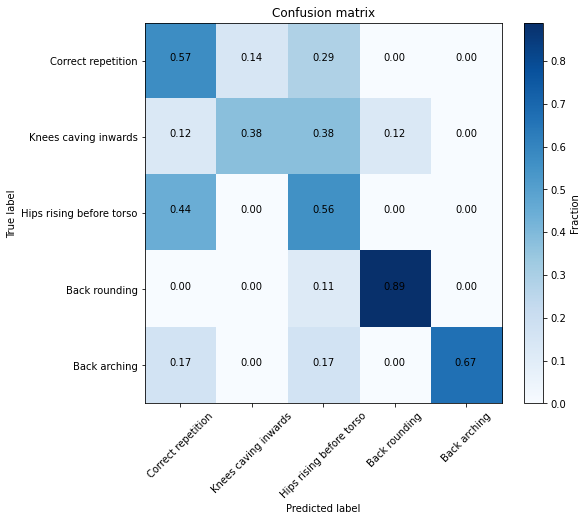

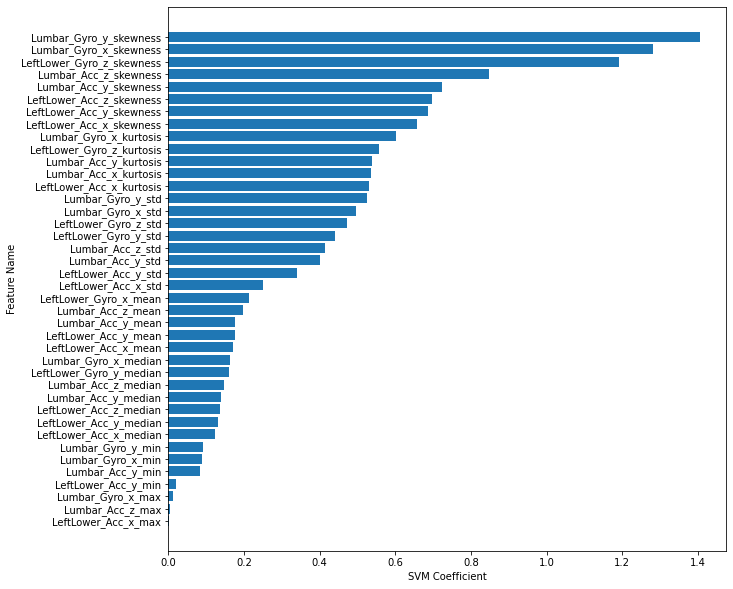

Tuned hyperparameters:
model__C        0.1
selector__k    40.0
Name: 0, dtype: float64
Highest accuracy: 0.75 at fold 18
Cross-validation accuracy: 0.54 +/- 0.10
Classification report:
                          precision    recall  f1-score   support

      Correct repetition       0.29      0.35      0.32        17
   Feet on the same line       0.75      0.53      0.62        17
Knee touching the ground       0.30      0.59      0.40        17
         Leaning forward       0.93      0.74      0.82        19
        Stride too short       1.00      0.45      0.62        20

                accuracy                           0.53        90
               macro avg       0.65      0.53      0.56        90
            weighted avg       0.67      0.53      0.56        90



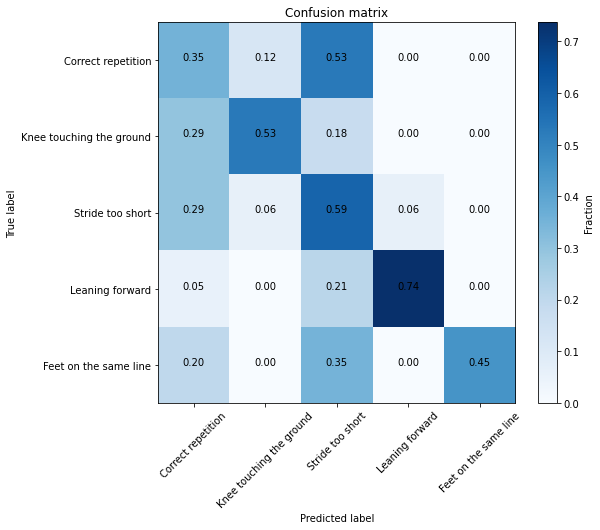

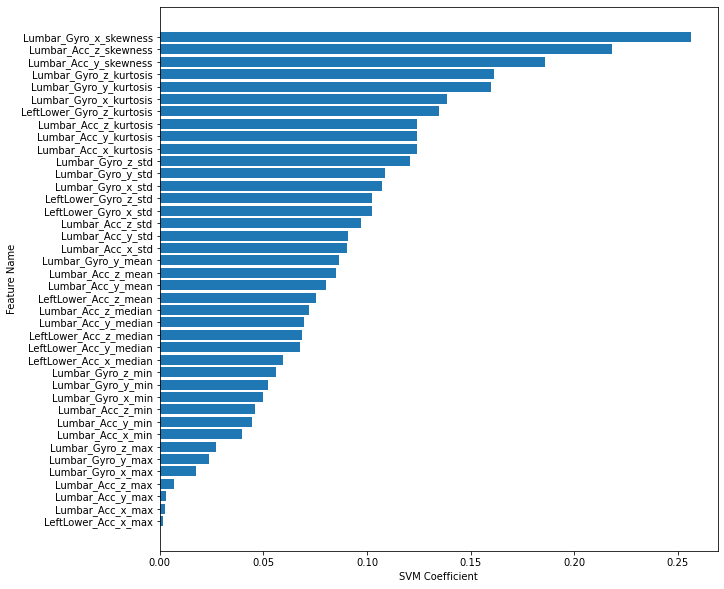

Tuned hyperparameters:
model__C        0.1
selector__k    10.0
Name: 0, dtype: float64
Highest accuracy: 0.79 at fold 15
Cross-validation accuracy: 0.66 +/- 0.08
Classification report:
                    precision    recall  f1-score   support

      Back arching       0.53      0.90      0.67        10
Correct repetition       0.75      0.33      0.46         9
    Feet too close       0.89      0.80      0.84        10
      Feet too far       0.71      1.00      0.83        10
  Insufficient ROM       1.00      0.00      0.00         5

          accuracy                           0.68        44
         macro avg       0.78      0.61      0.56        44
      weighted avg       0.75      0.68      0.63        44



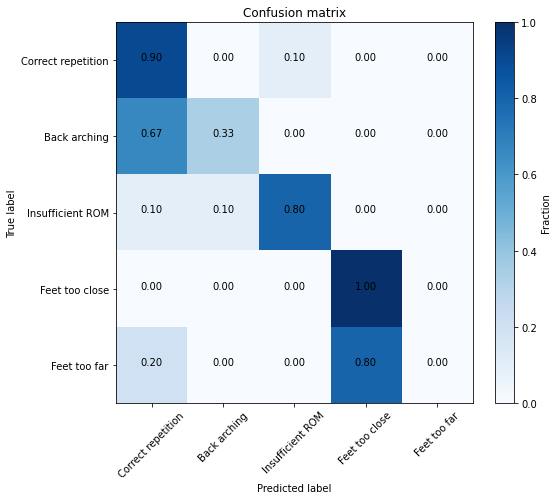

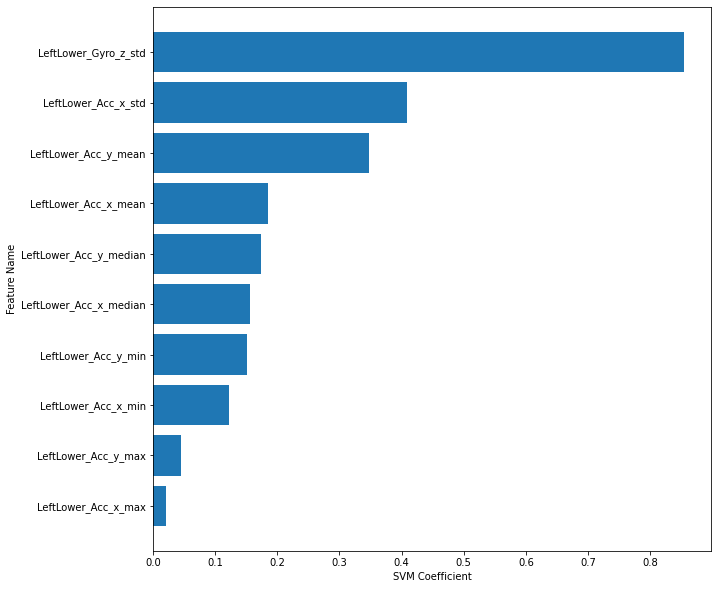

In [112]:
df = read_csv('statistical_features_')
training_df = prepare_df(df, secluded_sensors = ['Upper','RightLower'])
SVM('Squats',training_df)
SVM('Lunges',training_df)
SVM('Bridges',training_df)